## An attempt to work out different rooting depths and distributions for savanna sites in Northern Australia
----------

The below technique follows from the SPA version 1 calibration spreadsheet for calculating the root profile of a canopy. My madness on screen as displayed here is to determine whether I can build this in to a parameter estimation workflow in some emulator work saved elsewhere.

Libraries to import

In [182]:
from scipy.optimize import minimize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

Notebook plot settings

In [2]:
plt.style.use(['dark_background', 'presentation'])

### Describing the root profile

The distribution of root biomass follows the following conditional equation:

\begin{equation}
r_{mass, z}=
    \begin{cases}
        r_{mass, surf}\left(\frac{-\exp({k_{z}\space d_{z}})\space+\space\exp({k_{z}\space d_{z-1}})}{k_{z}}\right), & \text{if}\ z < z_{root, max} \\\\
        0, & \text{else}
    \end{cases}
\end{equation}

where $r_{mass, z}$ is the root biomass (in grams) at some arbitrary depth $z$, $r_{mass, surf}$ is the root biomass at the soil surface interface, $k_{z}$ is the decline coefficient, and $d_{z}$ is the current depth of the soil, and $z_{root, max}$ is the maximum rooting depth.

The density of roots for each layer is then determined as:

\begin{equation}
    r_{dens, z} = \frac{r_{mass, z}}{z_{thick}}
\end{equation}

And finally the fraction of roots at some aribtrary depth $z$ is determed as:

\begin{equation}
    r_{frac, z} = \frac{r_{dens, z}}{r_{mass, total}}
\end{equation}


The decline coefficient seems to be site-specific and this pre-determined via optimising on it.

\begin{equation}
    \chi_{\min}^{2} = \min\left( r_{mass, total} - \sum_{z=0}^{N{r}} r_{mass, z}(k_{z}) \right)
\end{equation}

We can now use these equations to come up with a set of shallow-to-deep root profiles based on collected site information.

### Example case: Howard Springs

Known prior information to work with:

$r_{mass, total} = 1930 \space g\space m^{-2}$

$r_{mass, surf} = 14000 \space g\space m^{-3}$

$z_{root, max} = 6.0 \space m$


Assume an A/B horizon for the soil profile based on the protocol soils table

**Horizon A:** 55 % sand | 5 % clay

**Horizon B:** 45 % sand | 10 % clay

Also assume the following soil profile (**this is not the root profile**)

In [188]:
# create 20 soil layers
soil_layer = np.arange(20)

# set the thicknesses of the 20 soil layers, divide accordingly to match with field measurements
soil_thick = [0.1 if z < 4 else 0.2 if (z >= 4) & (z < 12) else 1.0 for z in soil_layer]

soil_depth = np.cumsum([0] + soil_thick)

# create a dataframe to work with
soil_df = pd.DataFrame({'thick': soil_thick, 'depth': soil_depth[:-1]}, index=soil_layer+1)
#soil_df

Now create a function to determine the root biomass per soil layer

In [72]:
def root_biom(rz_a, rz_b, kd, rdsurf):
    """
    rz_a = root layer at depth A
    rz_b = root layer at depth B
    kd = decay coefficient
    rdsurf = root density at the surface
    """
    return rdsurf*(-1/kd*np.exp(-kd*rz_a) + 1/kd*np.exp(-kd*rz_b))

# [test:: not run]
#[root_biom(soil_df.depth.values[i], soil_df.depth.values[i-1], 3.5, 14000) for i in range(len(soil_df)) if i > 0]

We now want to create the *cost-function* to determine our extinction coefficient and therefore the distribution of roots through the profile. We're using the scipy's optimise package as it is really fast.

In [170]:
def root_biom_vx(kd_, rd_surf_, x_depth):
    return [root_biom(x_depth[i], x_depth[i-1], kd_, rd_surf_) \
                          for i in range(len(x_depth)) if i > 0]

# cost function to minimise on [don't like this being nested] 
def cost_fun(kd_, rd_surf_, r_totbiom_, x_depth):
        
    root_bk = root_biom_vx(kd_, rd_surf_, x_depth)
    
    return abs(r_totbiom_ - sum(root_bk))

def get_root_dist(rb_total_, rd_surf_, x_depth_):
   
    # now find the coefficient
    res = minimize(cost_fun, 5, args=(rd_surf_, rb_total_, x_depth_), method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    # optimal parameter
    kd_0 = res.x[0]
    
    # now we can determine the root density per soil layer
    root_biom = root_biom_vx(kd_0, rd_surf_, x_depth_)
    # return to user
    return root_biom

Test that the above minimiser functions work accordingly... and they seem to do just fine. So lets test a bunch of profile and visualise what they might look like.

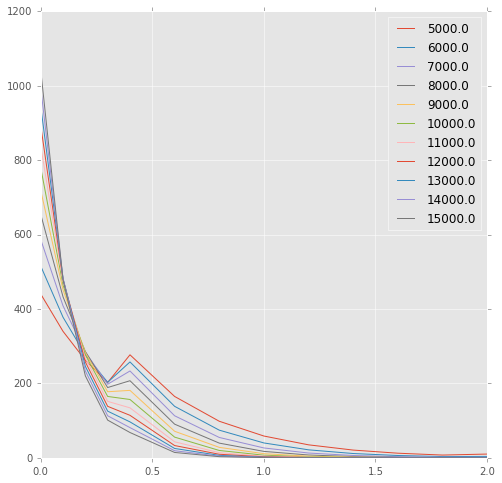

In [196]:
r_depth = soil_df.depth.values
rd_surf = 11000
rb_total = 1930

# test
rdens_list = np.linspace(5e3, 15e3, 11)

plt.figure(figsize=(8, 8))
for rd in rdens_list:
    rzd = soil_depth
    rbm = get_root_dist(rb_total, rd, rzd)
    plt.plot(rzd[:-1], rbm, label=rd)
plt.xlim([0, 2])
plt.legend()